# Benchmark Analysis - H6

In [26]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [27]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [28]:
matplotlib.style.use('seaborn-v0_8')  

In [29]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M_WITH_BYTES'

In [30]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [31]:
plot_save_dir = './plots/h6'

## Utils 

In [32]:
def get_path(*entries):
    return os.path.join(*entries)

In [33]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [34]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"))
    plt.show()

In [35]:
def extraction_pandas_frame_algo(path, COMP="TODO"):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [36]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [37]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [38]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [39]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [40]:
def get_strong_scaling_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(f'{root_dir}/{compiler_location}/DEFAULT/{bench_name}_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

# H6
> Parallel STL backends leverage specialized parallelism techniques for inclusive and exclusive scans, resulting in
> significant variations in performance and strong scaling properties.

## `b6_1_inclusive_scan_par`

In [41]:
benchmark_name = "b6_1_inclusive_scan"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b6_1_inclusive_scan_par`

Check how the runtime without constraining the threads develops with increasing input size

In [42]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b6_1_inclusive_scan_time_merged = pd.merge(*data, on='n')

b6_1_inclusive_scan_time_merged

,GCC(TBB),n,NVC(OMP)
0,4846.46,4,2.998180e+02
1,18023.10,8,3.019910e+02
2,32610.40,16,3.031460e+02
3,42764.10,32,3.108270e+02
4,50534.70,64,3.302200e+02
5,56718.10,128,3.757120e+02
6,61521.60,256,4.387420e+02
7,66456.30,512,6.125690e+02
8,71039.00,1024,8.410050e+02
9,76711.60,2048,1.369440e+03


### Strong Scaling - `b6_1_inclusive_scan_strong_par`
 
2^26 fixed input size with threads 1-64

In [43]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b6_1_inclusive_scan_strong_scaling_merged = pd.merge(*data, on='threads')

b6_1_inclusive_scan_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.167445,1.108761
1,2,1.199260,1.108343
2,4,1.206659,1.103755
3,8,1.122304,1.104192
4,16,1.078646,1.106969
5,32,0.615375,1.106227
6,64,1.051035,1.105740


In [44]:
## efficiency graph

b6_1_inclusive_scan_efficiency = b6_1_inclusive_scan_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b6_1_inclusive_scan_efficiency[f'{compiler_name}'] = b6_1_inclusive_scan_efficiency[f'{compiler_name}'] / b6_1_inclusive_scan_efficiency['threads']



b6_1_inclusive_scan_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.167445,1.108761
1,2,0.599630,0.554171
2,4,0.301665,0.275939
3,8,0.140288,0.138024
4,16,0.067415,0.069186
5,32,0.019230,0.034570
6,64,0.016422,0.017277


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_75825/3583944337.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


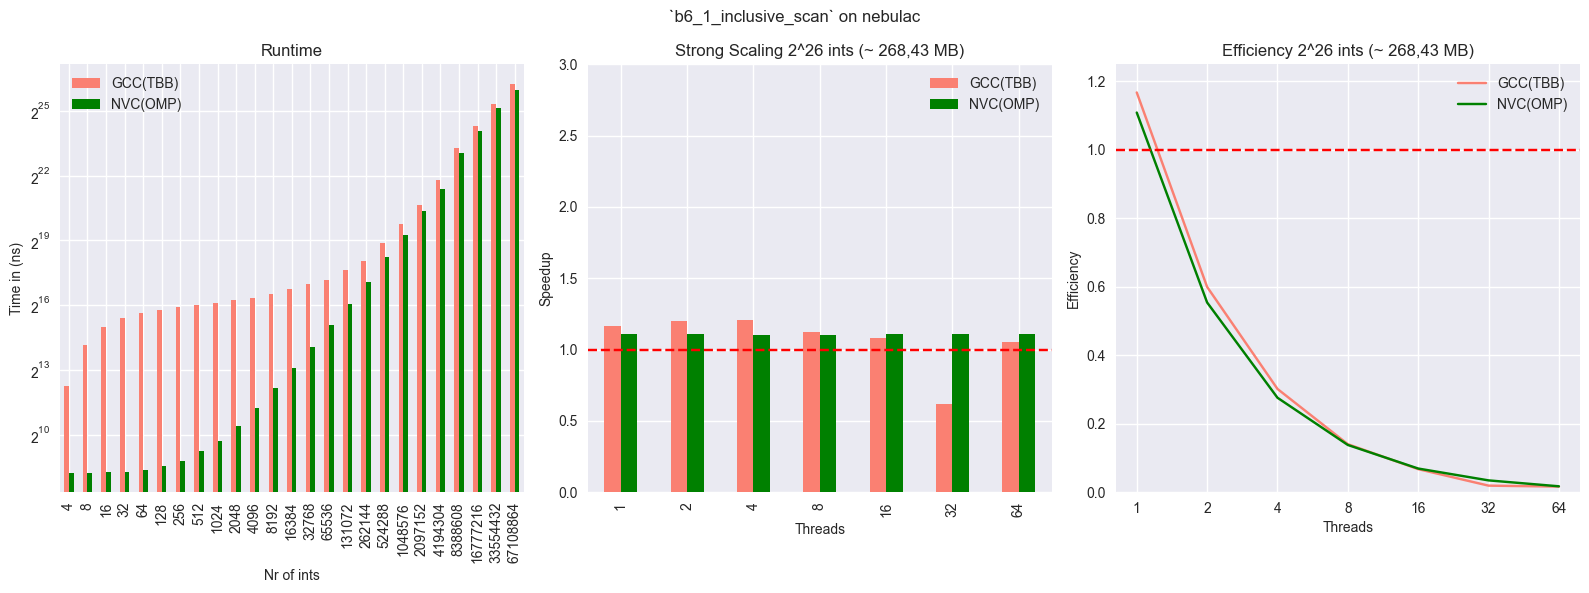

In [45]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b6_1_inclusive_scan_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b6_1_inclusive_scan_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b6_1_inclusive_scan_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b6_1_inclusive_scan` on nebulac")

fig.tight_layout()

plot("`b6_1_inclusive_scan` nebulac")

## `b6_2_exclusive_scan_par`

In [46]:
benchmark_name = "b6_2_exclusive_scan"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b6_2_exclusive_scan_par`

Check how the runtime without constraining the threads develops with increasing input size

In [47]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b6_2_exclusive_scan_time_merged = pd.merge(*data, on='n')

b6_2_exclusive_scan_time_merged

,GCC(TBB),n,NVC(OMP)
0,9916.49,4,3.055280e+02
1,21230.50,8,3.067500e+02
2,31281.50,16,3.101260e+02
3,40706.30,32,3.142380e+02
4,48933.20,64,3.386280e+02
5,54430.70,128,3.813690e+02
6,59130.30,256,4.442630e+02
7,65122.90,512,6.220430e+02
8,70019.30,1024,8.686600e+02
9,77057.10,2048,1.383730e+03


### Strong Scaling - `b6_2_exclusive_scan_strong_par`
 
2^26 fixed input size with threads 1-64

In [48]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b6_2_exclusive_scan_strong_scaling_merged = pd.merge(*data, on='threads')

b6_2_exclusive_scan_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.998880,1.104421
1,2,1.036587,1.104916
2,4,1.014820,1.106292
3,8,0.945392,1.103517
4,16,0.926341,1.103447
5,32,0.933552,1.105916
6,64,0.883250,1.104047


In [49]:
## efficiency graph

b6_2_exclusive_scan_efficiency = b6_2_exclusive_scan_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b6_2_exclusive_scan_efficiency[f'{compiler_name}'] = b6_2_exclusive_scan_efficiency[f'{compiler_name}'] / b6_2_exclusive_scan_efficiency['threads']



b6_2_exclusive_scan_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.998880,1.104421
1,2,0.518293,0.552458
2,4,0.253705,0.276573
3,8,0.118174,0.137940
4,16,0.057896,0.068965
5,32,0.029174,0.034560
6,64,0.013801,0.017251


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_75825/3871977296.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


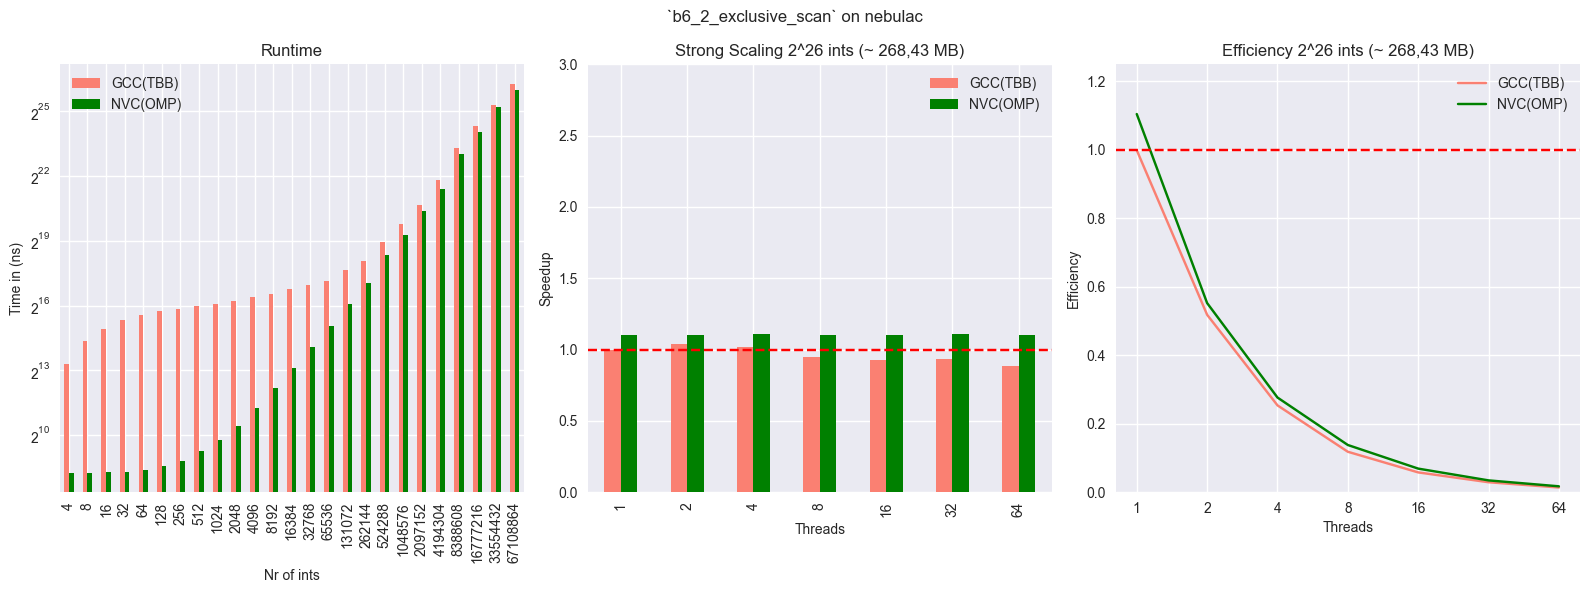

In [50]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b6_2_exclusive_scan_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b6_2_exclusive_scan_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b6_2_exclusive_scan_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b6_2_exclusive_scan` on nebulac")

fig.tight_layout()

plot("`b6_2_exclusive_scan` nebulac")

######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

Runtime

In [51]:
# calc pp_metrics

def calc_pp(data_points:List[int]) -> int:
    max_val = max(data_points)
    return len(data_points) / sum([1/(val/max_val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('b6_1_inclusive_scan',b6_1_inclusive_scan_time_merged),
    ('b6_2_exclusive_scan',b6_2_exclusive_scan_time_merged),
]

for data in data_fields:

    entry_dict = {
        'name': [data[0]],
    }

    vals = []

    for comp in compilers:
        current_val = int(data[1].iloc[-1][comp])
        entry_dict[comp] = [current_val]

        vals.append(current_val)

    entry_dict['PP'] = calc_pp(vals)

    other_df = pd.DataFrame.from_dict(entry_dict)
    pp_df = pd.concat([pp_df,other_df],ignore_index=True)


pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')

pp_df

,name,GCC(TBB),NVC(OMP),PP,INTERPRET
0,b6_1_inclusive_scan,81141300,65802700,0.895616,GOOD
1,b6_2_exclusive_scan,81700300,65664100,0.891180,GOOD


## Findings for H6

### XXX

### General


### GPU Findings


### Hypothesis Findings


